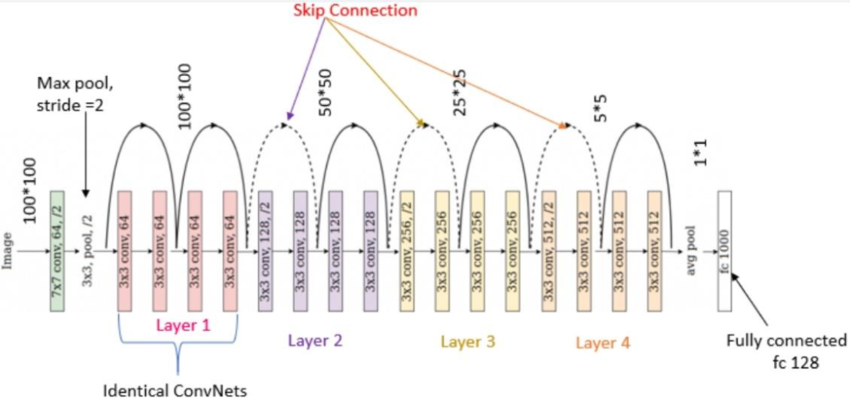

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
from PIL import Image


In [ ]:

# Load a pretrained ResNet model
model = resnet18(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Define a transformation pipeline for the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize the image to 224x224
    transforms.ToTensor(),           # Convert the image to a tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Load the image
image_path = "/content/drive/MyDrive/PYTORCH/car.jpg"  # Replace with your image file path
image = Image.open(image_path).convert("RGB")  # Ensure 3-channel RGB

# Apply the transformation to the image
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Perform the prediction
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted_class = outputs.max(1)
    print("💙" , predicted_class)  # Get the class index with the highest score

# Load class labels
import json
import urllib.request
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
labels = json.load(urllib.request.urlopen(url))

# Print the predicted class
predicted_label = labels[predicted_class.item()]
print(f"Predicted class: {predicted_label}")


💙 tensor([817])
Predicted class: sports car


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet18(num_classes=1000):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

def resnet34(num_classes=1000):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

# Example usage
def use_resnet(image_path):
    # Initialize the model
    model = resnet18(num_classes=10)  # Example for ResNet-18 with 10 classes
    model.eval()  # Set the model to evaluation mode

    # Define the image preprocessing pipeline
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

    # Perform a forward pass
    with torch.no_grad():
        output = model(input_tensor)

    # Print the output labels
    print("Output labels:", output.argmax(dim=1).item())

    return output

if __name__ == "__main__":
    image_path = "/content/drive/MyDrive/PYTORCH/car.jpg"  # Replace with the path to your image
    use_resnet(image_path)


Output labels: 1
